In [1]:
import numpy as np
import pickle
import os
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/DATA/publish/mocet/analysis/scripts')
from utils.base import get_minecraft_subjects, get_project_directory, get_configs

subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
configs = get_configs()

task = configs['task']

def RestructuringLogProcessor(log_fname):
    ref_x = 287
    ref_z = -155
    Positions = []
    Placing_events = []
    Breaking_events = []
    with open(log_fname, encoding='cp949') as f:
        Lines = f.readlines()
        count = 0
        for line in Lines:
            if "Player" in line:
                tokens = line.split()[1].split(",")
                time = tokens[7]
                x = tokens[2]
                z = tokens[4]
                yaw = tokens[5]
                pitch = tokens[6]
                Positions.append(np.array([time, x, z, yaw, pitch], dtype=np.double))
            if "Break" in line:
                tokens = line.split()[1].split(",")
                time = tokens[1]
                x = tokens[2]
                z = tokens[4]
                Breaking_events.append(np.array([time, x, z], dtype=np.double))
            if "Place" in line:
                tokens = line.split()[1].split(",")
                time = tokens[1]
                x = tokens[2]
                z = tokens[4]
                Placing_events.append(np.array([time, x, z], dtype=np.double))

    Positions = np.array(Positions)
    Positions[:,1] -= ref_x
    Positions[:,2] -= ref_z
    if len(Breaking_events) > 0:
        Breaking_events = np.array(Breaking_events)
        Breaking_events[:,1] -= ref_x
        Breaking_events[:,2] -= ref_z
    else:
        Breaking_events = np.zeros((0, 3))
    if len(Placing_events) > 0:
        Placing_events = np.array(Placing_events)
        Placing_events[:,1] -= ref_x
        Placing_events[:,2] -= ref_z
    else:
        Placing_events = np.zeros((0, 3))
    return Positions, Breaking_events, Placing_events


def getFenceCoordinate(player_x,player_y, player_roll, player_pitch, target_x, target_y, event_type=1):
    width = 1600
    height = 1000
    hFOV = 96
    vFOV = 70
    player_height = 1.62
    hFOV_angle_left = np.deg2rad(player_roll - hFOV/2)
    hFOV_angle_right = np.deg2rad(player_roll + hFOV/2)
    vFOV_angle_near = np.deg2rad(player_pitch + vFOV/2)
    vFOV_angle_far = np.deg2rad(player_pitch - vFOV/2)
    target_hAngle = np.arctan2((player_y - target_y -0.5), (player_x - target_x - 0.5)) + np.pi/2

    target_dist = np.sqrt((player_x -target_x - 0.5) ** 2 + (player_y - target_y - 0.5) ** 2)
    if event_type ==1:
        target_height = player_height - 0.5
    else:
        target_height = player_height
    target_vAngle = np.arctan(target_height / target_dist)

    target_coordinate_x = width*((target_hAngle-hFOV_angle_left)/(hFOV_angle_right - hFOV_angle_left))
    target_coordinate_y = height*((target_vAngle-vFOV_angle_far)/(vFOV_angle_near - vFOV_angle_far))
    
    return np.array([target_coordinate_x, target_coordinate_y])

gaze_types = ['mocet', 'polynomial', 'linear', 'uncorrected']
usable_data = pickle.load(open('../../data/usable_data_list.pkl', 'rb'))
subjects = []
for key in list(usable_data.keys()):
    subjects.append(key[0])
subjects = list(set(subjects))
subjects.sort()
print(subjects)

['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-015', 'sub-016', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-PBJ']


In [4]:
next_target_distance = {}
for gaze_type in gaze_types:
    next_target_distance[gaze_type] = []
for gaze_type in gaze_types:
    for subject in subjects:
        print(gaze_type, subject)
        average_hit = []
        sessions = subject_pool[subject].keys()
        for session in sessions:
            runs = subject_pool[subject][session]
            for r in runs:
                run = f'run-{r}'
                np.random.seed(0)
                key = (subject, session, task, run)
                if key in usable_data.keys():
                    #if usable_data[key][1] >= 1.0:
                        n_TRs = 510
                        gaze_root = f'../../data/corrected_eyetracking/{gaze_type}/{subject}/{session}'
                        gaze = np.load(f'{gaze_root}/{subject}_{session}_{task}_{run}_gaze_coordinate.npy')
                        gaze_dt = np.load(f'{gaze_root}/{subject}_{session}_{task}_{run}_gaze_timestamp.npy')

                        gameplay_root = f'/DATA/Minecraft_old/_DATA/gameplay/{subject}/{session}'
                        fname = os.path.join(gameplay_root, run, 'restructuring', "restructuring_log.txt")
                        Positions, Breaking_events, Placing_events = RestructuringLogProcessor(fname)

                        restructuring_events = np.zeros((Breaking_events.shape[0] + Placing_events.shape[0], 4), dtype=int)
                        restructuring_events[:Breaking_events.shape[0],:3] = Breaking_events
                        restructuring_events[:Breaking_events.shape[0],3] = 1
                        restructuring_events[Breaking_events.shape[0]:,:3] = Placing_events
                        restructuring_events[Breaking_events.shape[0]:,3] = 2
                        restructuring_events = restructuring_events[restructuring_events[:,0].argsort()]
                        restructuring_events = [event for event in restructuring_events]

                        for event in restructuring_events:
                            time = event[0]
                            event_type = event[3]
                            player_t = np.max(np.where(Positions[:,0] <= time)[0])
                            if player_t >= 200:
                                player_t_sequence = Positions[player_t-200+1:player_t+1,0]
                            else:
                                player_t_sequence = Positions[0:player_t+1,0]

                            hits = 0
                            for tt, player_tt in enumerate(player_t_sequence):
                                player_x, player_y, player_roll, player_yaw = Positions[np.max(np.where(Positions[:,0] <= player_tt)[0]),[1,2,3,4]]
                                fence_coordinate = getFenceCoordinate(player_x, player_y, player_roll, player_yaw, event[1], event[2], event_type=event_type)
                                if fence_coordinate[0] > -100 and fence_coordinate[0] < 1700 and fence_coordinate[1] > -100 and fence_coordinate[1] < 1100:
                                    event_time = player_tt/1600
                                    time_in_sec = (160+event_time)*1.6
                                    time_gaze = gaze[np.min(np.where(gaze_dt >= time_in_sec*1000)[0]),:]
                                    gaze_delta = np.array([time_gaze[0]-fence_coordinate[0], time_gaze[1] - fence_coordinate[1]])
                                    distance = np.sqrt(gaze_delta[0]**2 + gaze_delta[1]**2)/78
                                    if distance <= 2.0:
                                        hits += 1
                            average_hit.append(hits/200)
        next_target_distance[gaze_type].append(np.mean(average_hit)*100)

with open('next_target_distance.pkl', 'wb') as f:
    pickle.dump(next_target_distance, f)

mocet sub-003
mocet sub-004
mocet sub-005
mocet sub-006
mocet sub-008
mocet sub-009
mocet sub-010
mocet sub-011
mocet sub-015
mocet sub-016
mocet sub-018
mocet sub-019
mocet sub-020
mocet sub-021
mocet sub-022
mocet sub-023
mocet sub-024
mocet sub-PBJ
polynomial sub-003
polynomial sub-004
polynomial sub-005
polynomial sub-006
polynomial sub-008
polynomial sub-009
polynomial sub-010
polynomial sub-011
polynomial sub-015
polynomial sub-016
polynomial sub-018
polynomial sub-019
polynomial sub-020
polynomial sub-021
polynomial sub-022
polynomial sub-023
polynomial sub-024
polynomial sub-PBJ
linear sub-003
linear sub-004
linear sub-005
linear sub-006
linear sub-008
linear sub-009
linear sub-010
linear sub-011
linear sub-015
linear sub-016
linear sub-018
linear sub-019
linear sub-020
linear sub-021
linear sub-022
linear sub-023
linear sub-024
linear sub-PBJ
uncorrected sub-003
uncorrected sub-004
uncorrected sub-005
uncorrected sub-006
uncorrected sub-008
uncorrected sub-009
uncorrected sub-

TtestResult(statistic=np.float64(7.848605446721897), pvalue=np.float64(4.7296893938249763e-07), df=np.int64(17))
TtestResult(statistic=np.float64(10.147047760255976), pvalue=np.float64(1.2495067640314232e-08), df=np.int64(17))
TtestResult(statistic=np.float64(11.608042411653264), pvalue=np.float64(1.6695295235427586e-09), df=np.int64(17))
0.035395277230445


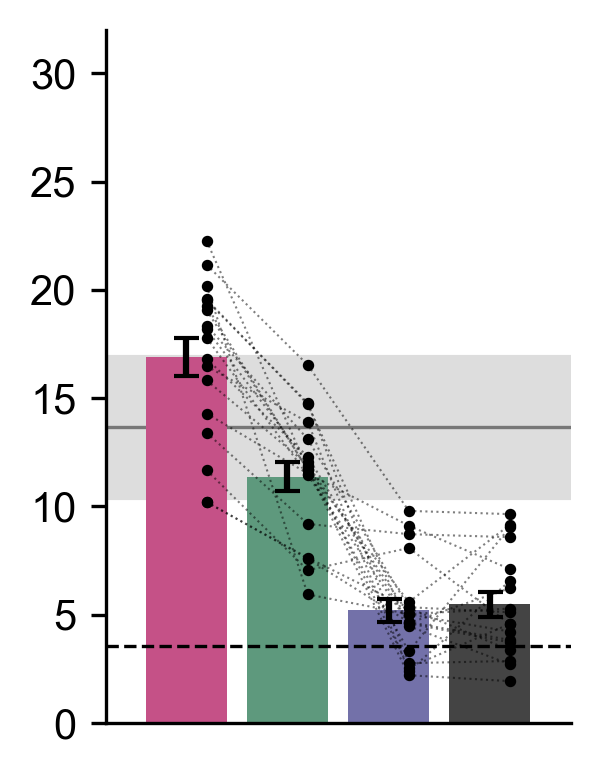

In [2]:
from scipy.stats import ttest_rel, sem

with open('next_target_distance.pkl', 'rb') as f:
    next_target_distance = pickle.load(f)

plt.style.use('default')
fig, axes = plt.subplots(1,1, sharey=True, sharex=True, figsize=(2,3), dpi=300)
color_list = ['#c55187','#5e997d', '#7371a9', '#444444']

print(ttest_rel(next_target_distance['mocet'], next_target_distance['polynomial'], nan_policy='omit'))
print(ttest_rel(next_target_distance['mocet'], next_target_distance['linear'], nan_policy='omit'))
print(ttest_rel(next_target_distance['mocet'], next_target_distance['uncorrected'], nan_policy='omit'))
#print(roi_name, ttest_rel(angle_statistics[roi_name]['mocet-6'], angle_statistics[roi_name]['uncorrected']))

beh_mean = 13.651795063876404
beh_std = 3.2461950920728304
axes.axhspan(beh_mean-beh_std, beh_mean+beh_std, color='#dddddd', zorder=0)
axes.axhline(beh_mean, c='#777777', zorder=1, lw=0.8)

axes.bar([0,1,2,3], [np.nanmean(next_target_distance['mocet']),
                        np.nanmean(next_target_distance['polynomial']),
                        np.nanmean(next_target_distance['linear']),
                        np.nanmean(next_target_distance['uncorrected']),
                        ],
              yerr= [sem(next_target_distance['mocet'],  nan_policy='omit'),
                        sem(next_target_distance['polynomial'],  nan_policy='omit'),
                        sem(next_target_distance['linear'],  nan_policy='omit'),
                        sem(next_target_distance['uncorrected'],  nan_policy='omit'),
                        ], color = color_list, capsize=3)
#axes.axhline(90, c='#777777', linestyle=":", lw=0.8)
for t, tag in enumerate(gaze_types):
    axes.scatter(t*np.ones(len(subjects))+0.2, next_target_distance[tag], s=3, c='k')
for s, subject in enumerate(subjects):
    axes.plot([0+0.2, 1+0.2], [next_target_distance['mocet'][s], next_target_distance['polynomial'][s]],
                   c='k', alpha=0.5, lw=0.5, linestyle=':')
    axes.plot([1+0.2, 2+0.2], [next_target_distance['polynomial'][s], next_target_distance['linear'][s]],
                   c='k', alpha=0.5, lw=0.5, linestyle=':')
    axes.plot([2+0.2, 3+0.2], [next_target_distance['linear'][s], next_target_distance['uncorrected'][s]],
                   c='k', alpha=0.5, lw=0.5, linestyle=':')

area = 1800 * 1200
hit_area = np.pi * (78*2)**2
print(hit_area / area)
axes.axhline(100*hit_area/area, c='k', lw=0.8, linestyle='--')
axes.set_ylim(0.0, 32)
axes.set_xlim(-0.8, 3.8)
axes.set_xticks([0,1,2,3])
axes.set_xticks([])
axes.set_xticklabels([])
axes.spines[['right', 'top']].set_visible(False)
plt.subplots_adjust(wspace=0.08)

for tick in axes.get_yticklabels():
    tick.set_fontname("Arial")
for tick in axes.get_xticklabels():
    tick.set_fontname("Arial")